#### Set experiment parameters in config
For training that terminates in a reasonable timeframe use data in sample_subset/audio.
This is not a real dataset as it consists of 10 images, but the functionality of the code can be examined.
The full dataset can be found here "https://magenta.withgoogle.com/datasets/nsynth#files" It must first be extracted, for example with the function in data_work.ipynb. To use the full dataset, preprocessing is recommend. A function for this purpose can also be found in the data_work notebook. To continue with the experiment, set the parameters of the config to something reasonable for your hardware like done bewlow:

In [2]:
import sys
import os
from pathlib import Path
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(''))))

notebook_dir = Path.cwd()  # Current working directory when notebook is run
project_root = notebook_dir.parent if notebook_dir.name == 'core' else notebook_dir
sys.path.insert(0, str(project_root))
from core.config import load_config
config = load_config()
config.vae.batch_size = 32
config.vae.epochs = 50

In [4]:
from core.train_vae import train, test, simple_kl_annealing
from core.datasets import HDF5SpectrogramDataset, collate_fn
from core.VAE_models import VAE, CVAE, CVAE_Deep, count_parameters, save_checkpoint

from datetime import datetime


from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision.transforms import v2
import torch

conv = True

# Define image transformation if wanted for regularization
transforms = v2.Compose([
    v2.RandomResizedCrop(size=(128, 172), antialias=True),
    v2.RandomHorizontalFlip(p=0.5)
    ])


train_data = HDF5SpectrogramDataset(project_root / 'data' / 'train_spectrograms_even.h5', transform=transforms)
test_data = HDF5SpectrogramDataset(project_root / 'data' / 'valid_spectrograms_even.h5')

train_loader = DataLoader(train_data, batch_size=config.vae.batch_size, shuffle=True, pin_memory=True, num_workers=8, persistent_workers=True, prefetch_factor=2)
test_loader = DataLoader(test_data, batch_size=config.vae.batch_size, shuffle=False, pin_memory=True, num_workers=4, persistent_workers=True)

sample_spec = train_data[0] # Sample spectogram 
in_dim = sample_spec.numel() # For spectograms = width * height
image_size = tuple(sample_spec.size())

timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = os.path.join(config.log_dir, timestamp)
os.makedirs(log_dir, exist_ok=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(device)

if conv:
    model = CVAE([128, 172], config.vae.latent_dim, 0.0).to(device)
else:
    model = VAE(in_dim, config.vae.latent_dim, config.vae.n_layers, config.vae.beta_kl).to(device)

print(count_parameters(model))

torch.set_float32_matmul_precision("medium")

optimizer = torch.optim.Adam(model.parameters(), lr=config.vae.lr, weight_decay=config.vae.weight_decay, decoupled_weight_decay=True)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config.vae.epochs)
writer = SummaryWriter(log_dir)
prev_updates = 0
best_loss = torch.tensor(float('Inf'))
for epoch in range(config.vae.epochs):
    print(f'Epoch {epoch+1}/{config.vae.epochs}')
    beta = simple_kl_annealing(epoch, config.vae.epochs, num_cycles=4)
    print(f'using beta: {beta}')
    model.set_beta(beta)
    prev_updates = train(model, train_loader, optimizer, prev_updates, config, device=device, writer=writer, conv=conv)
    scheduler.step()
    test_loss, test_recon_loss, test_kl_loss = test(model, test_loader, prev_updates, config, device, writer=writer, conv=conv)
    if test_recon_loss < best_loss:
        best_loss = test_recon_loss
        if conv:
            save_checkpoint(model, optimizer, epoch, test_kl_loss, config, image_size)
        else:
            save_checkpoint(model, optimizer, epoch, test_kl_loss, config, in_dim)
    


cuda
34833793
Epoch 1/50
using beta: 0.01


  0%|          | 2/9038 [00:00<55:29,  2.71it/s]  

Step 0 (N samples: 0), Loss: 8715.4463 (Recon: 8715.4453, KL: 0.0006) Grad: 5217.0664


  6%|▌         | 510/9038 [00:12<03:09, 44.99it/s]

Step 500 (N samples: 16,000), Loss: 1437.9862 (Recon: 1419.9674, KL: 18.0188) Grad: 608.1928


 11%|█         | 1007/9038 [00:24<03:10, 42.09it/s]

Step 1,000 (N samples: 32,000), Loss: 990.3881 (Recon: 976.4198, KL: 13.9682) Grad: 751.2042


 17%|█▋        | 1508/9038 [00:36<03:01, 41.59it/s]

Step 1,500 (N samples: 48,000), Loss: 1197.3306 (Recon: 1185.2482, KL: 12.0824) Grad: 402.6227


 22%|██▏       | 2004/9038 [00:48<02:59, 39.29it/s]

Step 2,000 (N samples: 64,000), Loss: 983.0767 (Recon: 971.7187, KL: 11.3580) Grad: 359.3757


 28%|██▊       | 2508/9038 [01:00<02:52, 37.87it/s]

Step 2,500 (N samples: 80,000), Loss: 709.8454 (Recon: 697.8328, KL: 12.0126) Grad: 914.8979


 33%|███▎      | 3006/9038 [01:12<02:30, 40.18it/s]

Step 3,000 (N samples: 96,000), Loss: 835.8913 (Recon: 823.6765, KL: 12.2148) Grad: 334.6642


 39%|███▉      | 3507/9038 [01:25<02:10, 42.32it/s]

Step 3,500 (N samples: 112,000), Loss: 784.6757 (Recon: 770.4965, KL: 14.1793) Grad: 2072.4538


 44%|████▍     | 4004/9038 [01:38<02:03, 40.71it/s]

Step 4,000 (N samples: 128,000), Loss: 799.9607 (Recon: 785.3528, KL: 14.6079) Grad: 1311.7084


 50%|████▉     | 4505/9038 [01:50<01:53, 40.08it/s]

Step 4,500 (N samples: 144,000), Loss: 670.3599 (Recon: 654.9925, KL: 15.3674) Grad: 1159.3054


 55%|█████▌    | 5005/9038 [02:02<01:36, 41.68it/s]

Step 5,000 (N samples: 160,000), Loss: 769.1950 (Recon: 754.4597, KL: 14.7354) Grad: 1683.0847


 61%|██████    | 5505/9038 [02:14<01:25, 41.09it/s]

Step 5,500 (N samples: 176,000), Loss: 542.2684 (Recon: 528.6179, KL: 13.6505) Grad: 2546.1268


 66%|██████▋   | 6007/9038 [02:26<01:20, 37.88it/s]

Step 6,000 (N samples: 192,000), Loss: 659.9926 (Recon: 646.4553, KL: 13.5372) Grad: 1434.3808


 72%|███████▏  | 6506/9038 [02:39<01:07, 37.50it/s]

Step 6,500 (N samples: 208,000), Loss: 719.4782 (Recon: 704.0334, KL: 15.4448) Grad: 1498.0387


 78%|███████▊  | 7006/9038 [02:53<00:52, 38.58it/s]

Step 7,000 (N samples: 224,000), Loss: 464.5616 (Recon: 451.1426, KL: 13.4190) Grad: 2332.3245


 83%|████████▎ | 7508/9038 [03:07<00:43, 35.31it/s]

Step 7,500 (N samples: 240,000), Loss: 748.4164 (Recon: 731.9624, KL: 16.4540) Grad: 2595.9100


 89%|████████▊ | 8008/9038 [03:20<00:27, 37.33it/s]

Step 8,000 (N samples: 256,000), Loss: 439.8473 (Recon: 427.9044, KL: 11.9428) Grad: 778.8656


 94%|█████████▍| 8506/9038 [03:33<00:14, 37.25it/s]

Step 8,500 (N samples: 272,000), Loss: 456.0437 (Recon: 442.0880, KL: 13.9557) Grad: 1540.8384


100%|█████████▉| 9004/9038 [03:47<00:01, 31.51it/s]

Step 9,000 (N samples: 288,000), Loss: 344.2830 (Recon: 333.7346, KL: 10.5483) Grad: 1058.1297


Testing: 100%|██████████| 397/397 [00:06<00:00, 60.74it/s]


====> Test set loss: 736.5633 (BCE: 721.8756, KLD: 14.6877)
Model saved at: ./models/conv_vae/c_vae_checkpoint_20250801-024624.pt
Epoch 2/50
using beta: 0.04817536741017153


  5%|▌         | 470/9038 [00:15<04:04, 35.10it/s]

Step 9,500 (N samples: 304,000), Loss: 532.6799 (Recon: 493.5783, KL: 39.1016) Grad: 1070.4773


 11%|█         | 967/9038 [00:29<03:51, 34.91it/s]

Step 10,000 (N samples: 320,000), Loss: 536.8034 (Recon: 501.2583, KL: 35.5451) Grad: 1378.2774


 16%|█▋        | 1470/9038 [00:45<03:24, 37.00it/s]

Step 10,500 (N samples: 336,000), Loss: 415.4916 (Recon: 384.6645, KL: 30.8271) Grad: 1639.0964


 22%|██▏       | 1968/9038 [00:59<03:47, 31.07it/s]

Step 11,000 (N samples: 352,000), Loss: 423.2764 (Recon: 391.6007, KL: 31.6757) Grad: 1933.8788


 27%|██▋       | 2468/9038 [01:14<03:33, 30.76it/s]

Step 11,500 (N samples: 368,000), Loss: 424.4002 (Recon: 390.0519, KL: 34.3483) Grad: 536.3269


 33%|███▎      | 2970/9038 [01:28<02:54, 34.75it/s]

Step 12,000 (N samples: 384,000), Loss: 511.4810 (Recon: 474.4452, KL: 37.0358) Grad: 3274.2124


 38%|███▊      | 3468/9038 [01:42<02:27, 37.76it/s]

Step 12,500 (N samples: 400,000), Loss: 474.4525 (Recon: 435.6881, KL: 38.7643) Grad: 2249.9440


 44%|████▍     | 3966/9038 [01:55<02:26, 34.53it/s]

Step 13,000 (N samples: 416,000), Loss: 440.1907 (Recon: 411.9812, KL: 28.2095) Grad: 2087.8240


 49%|████▉     | 4468/9038 [02:07<01:50, 41.25it/s]

Step 13,500 (N samples: 432,000), Loss: 475.6054 (Recon: 443.2789, KL: 32.3265) Grad: 1365.2397


 55%|█████▍    | 4970/9038 [02:20<01:52, 36.10it/s]

Step 14,000 (N samples: 448,000), Loss: 384.6642 (Recon: 352.9116, KL: 31.7525) Grad: 492.5912


 61%|██████    | 5468/9038 [02:32<01:35, 37.23it/s]

Step 14,500 (N samples: 464,000), Loss: 474.3157 (Recon: 438.4792, KL: 35.8364) Grad: 3208.2688


 66%|██████▌   | 5968/9038 [02:45<01:09, 43.95it/s]

Step 15,000 (N samples: 480,000), Loss: 423.7153 (Recon: 391.6131, KL: 32.1022) Grad: 964.5813


 72%|███████▏  | 6468/9038 [02:56<00:59, 43.20it/s]

Step 15,500 (N samples: 496,000), Loss: 290.2576 (Recon: 264.2115, KL: 26.0462) Grad: 441.4262


 77%|███████▋  | 6968/9038 [03:08<00:47, 43.21it/s]

Step 16,000 (N samples: 512,000), Loss: 351.5878 (Recon: 323.8440, KL: 27.7437) Grad: 671.9574


 83%|████████▎ | 7468/9038 [03:19<00:35, 44.30it/s]

Step 16,500 (N samples: 528,000), Loss: 468.9685 (Recon: 435.0949, KL: 33.8736) Grad: 1039.7728


 88%|████████▊ | 7968/9038 [03:30<00:25, 42.61it/s]

Step 17,000 (N samples: 544,000), Loss: 349.6053 (Recon: 318.3622, KL: 31.2432) Grad: 1200.2097


 94%|█████████▎| 8470/9038 [03:42<00:12, 44.36it/s]

Step 17,500 (N samples: 560,000), Loss: 432.4179 (Recon: 399.5422, KL: 32.8757) Grad: 677.9666


 99%|█████████▉| 8970/9038 [03:53<00:01, 43.38it/s]

Step 18,000 (N samples: 576,000), Loss: 451.8660 (Recon: 416.7368, KL: 35.1292) Grad: 2235.7057


Testing: 100%|██████████| 397/397 [00:03<00:00, 119.75it/s]


====> Test set loss: 625.7531 (BCE: 589.5122, KLD: 36.2408)
Model saved at: ./models/conv_vae/c_vae_checkpoint_20250801-025024.pt
Epoch 3/50
using beta: 0.16886558510040303


  5%|▍         | 431/9038 [00:10<04:03, 35.35it/s]

Step 18,500 (N samples: 592,000), Loss: 493.9285 (Recon: 410.5403, KL: 83.3882) Grad: 1319.1222


 10%|█         | 931/9038 [00:23<03:21, 40.27it/s]

Step 19,000 (N samples: 608,000), Loss: 319.6438 (Recon: 261.5829, KL: 58.0609) Grad: 1025.1113


 16%|█▌        | 1431/9038 [00:36<03:30, 36.12it/s]

Step 19,500 (N samples: 624,000), Loss: 430.8257 (Recon: 365.8235, KL: 65.0022) Grad: 1735.3799


 21%|██▏       | 1928/9038 [00:49<03:25, 34.62it/s]

Step 20,000 (N samples: 640,000), Loss: 456.5961 (Recon: 391.3042, KL: 65.2919) Grad: 2634.8572


 27%|██▋       | 2429/9038 [01:01<02:48, 39.14it/s]

Step 20,500 (N samples: 656,000), Loss: 489.5045 (Recon: 419.1154, KL: 70.3890) Grad: 864.1295


 32%|███▏      | 2932/9038 [01:14<02:24, 42.37it/s]

Step 21,000 (N samples: 672,000), Loss: 475.8575 (Recon: 408.2650, KL: 67.5925) Grad: 2417.6206


 38%|███▊      | 3428/9038 [01:26<02:21, 39.77it/s]

Step 21,500 (N samples: 688,000), Loss: 571.3414 (Recon: 492.7581, KL: 78.5833) Grad: 666.5454


 43%|████▎     | 3931/9038 [01:43<02:25, 35.22it/s]

Step 22,000 (N samples: 704,000), Loss: 441.7382 (Recon: 370.7296, KL: 71.0086) Grad: 3258.9118


 49%|████▉     | 4431/9038 [02:01<01:53, 40.70it/s]

Step 22,500 (N samples: 720,000), Loss: 512.1166 (Recon: 444.3943, KL: 67.7223) Grad: 3332.9590


 55%|█████▍    | 4931/9038 [02:13<01:36, 42.58it/s]

Step 23,000 (N samples: 736,000), Loss: 438.2370 (Recon: 369.7816, KL: 68.4554) Grad: 2829.6889


 60%|██████    | 5432/9038 [02:25<01:34, 38.13it/s]

Step 23,500 (N samples: 752,000), Loss: 382.0475 (Recon: 323.4221, KL: 58.6254) Grad: 988.8172


 66%|██████▌   | 5929/9038 [02:37<01:16, 40.45it/s]

Step 24,000 (N samples: 768,000), Loss: 355.1608 (Recon: 297.7646, KL: 57.3963) Grad: 855.1297


 71%|███████   | 6429/9038 [02:50<01:08, 38.33it/s]

Step 24,500 (N samples: 784,000), Loss: 427.2102 (Recon: 360.3916, KL: 66.8186) Grad: 2574.8295


 77%|███████▋  | 6932/9038 [03:02<00:51, 40.70it/s]

Step 25,000 (N samples: 800,000), Loss: 450.4226 (Recon: 384.2216, KL: 66.2010) Grad: 1976.5666


 82%|████████▏ | 7432/9038 [03:14<00:38, 42.15it/s]

Step 25,500 (N samples: 816,000), Loss: 465.6683 (Recon: 400.3383, KL: 65.3300) Grad: 1011.9666


 88%|████████▊ | 7930/9038 [03:25<00:30, 36.64it/s]

Step 26,000 (N samples: 832,000), Loss: 366.8503 (Recon: 305.9504, KL: 60.8998) Grad: 537.4063


 93%|█████████▎| 8431/9038 [03:37<00:14, 42.73it/s]

Step 26,500 (N samples: 848,000), Loss: 370.1406 (Recon: 307.4652, KL: 62.6753) Grad: 927.8724


 99%|█████████▉| 8931/9038 [03:49<00:02, 44.47it/s]

Step 27,000 (N samples: 864,000), Loss: 431.1382 (Recon: 363.9695, KL: 67.1687) Grad: 1892.6239


Testing: 100%|██████████| 397/397 [00:03<00:00, 112.98it/s]


====> Test set loss: 629.2474 (BCE: 550.0238, KLD: 79.2236)
Model saved at: ./models/conv_vae/c_vae_checkpoint_20250801-025420.pt
Epoch 4/50
using beta: 0.29940801852848153


  4%|▍         | 395/9038 [00:09<03:18, 43.53it/s]

Step 27,500 (N samples: 880,000), Loss: 577.5494 (Recon: 457.7659, KL: 119.7835) Grad: 2188.9283


 10%|▉         | 894/9038 [00:20<03:06, 43.64it/s]

Step 28,000 (N samples: 896,000), Loss: 557.0275 (Recon: 452.7271, KL: 104.3004) Grad: 3772.3495


 15%|█▌        | 1392/9038 [00:32<02:52, 44.26it/s]

Step 28,500 (N samples: 912,000), Loss: 439.9872 (Recon: 350.4891, KL: 89.4981) Grad: 2235.0769


 21%|██        | 1894/9038 [00:44<02:55, 40.79it/s]

Step 29,000 (N samples: 928,000), Loss: 541.2784 (Recon: 430.7525, KL: 110.5260) Grad: 1370.8593


 26%|██▋       | 2393/9038 [00:56<02:36, 42.54it/s]

Step 29,500 (N samples: 944,000), Loss: 334.4645 (Recon: 257.8820, KL: 76.5825) Grad: 1009.5194


 32%|███▏      | 2893/9038 [01:09<02:38, 38.69it/s]

Step 30,000 (N samples: 960,000), Loss: 416.9626 (Recon: 332.0219, KL: 84.9408) Grad: 2134.3050


 38%|███▊      | 3394/9038 [01:21<02:20, 40.23it/s]

Step 30,500 (N samples: 976,000), Loss: 459.4172 (Recon: 357.7775, KL: 101.6396) Grad: 1664.3902


 43%|████▎     | 3893/9038 [01:33<02:02, 41.96it/s]

Step 31,000 (N samples: 992,000), Loss: 488.6703 (Recon: 388.8180, KL: 99.8524) Grad: 2905.6195


 49%|████▊     | 4393/9038 [01:44<01:43, 44.72it/s]

Step 31,500 (N samples: 1,008,000), Loss: 420.7230 (Recon: 322.0849, KL: 98.6380) Grad: 1398.4618


 54%|█████▍    | 4893/9038 [01:56<01:39, 41.60it/s]

Step 32,000 (N samples: 1,024,000), Loss: 658.7510 (Recon: 538.2745, KL: 120.4765) Grad: 2435.0339


 60%|█████▉    | 5391/9038 [02:08<01:26, 41.99it/s]

Step 32,500 (N samples: 1,040,000), Loss: 465.8430 (Recon: 368.6609, KL: 97.1822) Grad: 2074.4884


 65%|██████▌   | 5892/9038 [02:20<01:16, 40.95it/s]

Step 33,000 (N samples: 1,056,000), Loss: 516.6409 (Recon: 406.6312, KL: 110.0098) Grad: 798.4144


 71%|███████   | 6391/9038 [02:32<01:00, 43.79it/s]

Step 33,500 (N samples: 1,072,000), Loss: 420.3126 (Recon: 330.2153, KL: 90.0973) Grad: 967.0031


 76%|███████▋  | 6892/9038 [02:44<00:51, 41.40it/s]

Step 34,000 (N samples: 1,088,000), Loss: 554.6534 (Recon: 440.3828, KL: 114.2706) Grad: 4688.2451


 82%|████████▏ | 7391/9038 [02:55<00:38, 42.95it/s]

Step 34,500 (N samples: 1,104,000), Loss: 453.6555 (Recon: 362.0026, KL: 91.6529) Grad: 412.4838


 87%|████████▋ | 7895/9038 [03:07<00:26, 43.35it/s]

Step 35,000 (N samples: 1,120,000), Loss: 359.5758 (Recon: 276.9157, KL: 82.6601) Grad: 3617.7536


 93%|█████████▎| 8395/9038 [03:19<00:14, 44.32it/s]

Step 35,500 (N samples: 1,136,000), Loss: 343.4807 (Recon: 267.7632, KL: 75.7175) Grad: 1263.3757


 98%|█████████▊| 8895/9038 [03:30<00:03, 43.56it/s]

Step 36,000 (N samples: 1,152,000), Loss: 498.3786 (Recon: 392.2371, KL: 106.1416) Grad: 1601.8095


Testing: 100%|██████████| 397/397 [00:03<00:00, 128.62it/s]


====> Test set loss: 650.3174 (BCE: 539.2355, KLD: 111.0818)
Model saved at: ./models/conv_vae/c_vae_checkpoint_20250801-025759.pt
Epoch 5/50
using beta: 0.36193082098640783


  4%|▍         | 355/9038 [00:08<03:15, 44.49it/s]

Step 36,500 (N samples: 1,168,000), Loss: 529.9792 (Recon: 406.4137, KL: 123.5655) Grad: 1092.3772


  9%|▉         | 855/9038 [00:19<03:00, 45.30it/s]

Step 37,000 (N samples: 1,184,000), Loss: 381.2595 (Recon: 291.6313, KL: 89.6282) Grad: 714.6970


 15%|█▍        | 1355/9038 [00:30<03:05, 41.43it/s]

Step 37,500 (N samples: 1,200,000), Loss: 422.1204 (Recon: 326.1743, KL: 95.9462) Grad: 1008.6361


 21%|██        | 1855/9038 [00:41<02:45, 43.51it/s]

Step 38,000 (N samples: 1,216,000), Loss: 447.5323 (Recon: 341.3184, KL: 106.2139) Grad: 1031.6020


 26%|██▌       | 2357/9038 [00:54<02:33, 43.50it/s]

Step 38,500 (N samples: 1,232,000), Loss: 507.8560 (Recon: 386.1574, KL: 121.6985) Grad: 803.9124


 32%|███▏      | 2852/9038 [01:05<02:34, 40.13it/s]

Step 39,000 (N samples: 1,248,000), Loss: 416.1500 (Recon: 311.1726, KL: 104.9774) Grad: 705.3288


 37%|███▋      | 3355/9038 [01:17<02:16, 41.74it/s]

Step 39,500 (N samples: 1,264,000), Loss: 398.9825 (Recon: 296.8328, KL: 102.1497) Grad: 1766.5278


 43%|████▎     | 3855/9038 [01:29<02:01, 42.57it/s]

Step 40,000 (N samples: 1,280,000), Loss: 385.5371 (Recon: 287.8704, KL: 97.6667) Grad: 1001.7127


 48%|████▊     | 4356/9038 [01:41<02:00, 38.77it/s]

Step 40,500 (N samples: 1,296,000), Loss: 484.3479 (Recon: 376.5309, KL: 107.8170) Grad: 1357.1379


 54%|█████▎    | 4856/9038 [01:54<01:36, 43.40it/s]

Step 41,000 (N samples: 1,312,000), Loss: 336.5769 (Recon: 248.7467, KL: 87.8303) Grad: 1596.5432


 59%|█████▉    | 5355/9038 [02:05<01:23, 44.01it/s]

Step 41,500 (N samples: 1,328,000), Loss: 397.2503 (Recon: 308.3876, KL: 88.8627) Grad: 574.6341


 65%|██████▍   | 5855/9038 [02:17<01:12, 44.19it/s]

Step 42,000 (N samples: 1,344,000), Loss: 425.9679 (Recon: 322.5380, KL: 103.4299) Grad: 1813.7537


 70%|███████   | 6355/9038 [02:28<01:02, 43.02it/s]

Step 42,500 (N samples: 1,360,000), Loss: 418.0766 (Recon: 323.1043, KL: 94.9723) Grad: 1278.8998


 76%|███████▌  | 6855/9038 [02:39<00:53, 40.73it/s]

Step 43,000 (N samples: 1,376,000), Loss: 474.3863 (Recon: 365.4689, KL: 108.9173) Grad: 820.6643


 81%|████████▏ | 7355/9038 [02:51<00:38, 43.62it/s]

Step 43,500 (N samples: 1,392,000), Loss: 484.7957 (Recon: 374.6207, KL: 110.1750) Grad: 3518.3278


 87%|████████▋ | 7855/9038 [03:03<00:27, 43.27it/s]

Step 44,000 (N samples: 1,408,000), Loss: 402.4686 (Recon: 299.3647, KL: 103.1039) Grad: 1113.9523


 92%|█████████▏| 8354/9038 [03:14<00:15, 43.62it/s]

Step 44,500 (N samples: 1,424,000), Loss: 382.1612 (Recon: 280.1798, KL: 101.9814) Grad: 1632.0870


 98%|█████████▊| 8854/9038 [03:25<00:04, 42.91it/s]

Step 45,000 (N samples: 1,440,000), Loss: 409.6457 (Recon: 314.6362, KL: 95.0094) Grad: 390.9100


Testing: 100%|██████████| 397/397 [00:03<00:00, 111.63it/s]


====> Test set loss: 635.3152 (BCE: 508.8848, KLD: 126.4305)
Model saved at: ./models/conv_vae/c_vae_checkpoint_20250801-030133.pt
Epoch 6/50
using beta: 0.2938926261462366


  4%|▎         | 317/9038 [00:07<03:29, 41.65it/s]

Step 45,500 (N samples: 1,456,000), Loss: 415.3900 (Recon: 321.3954, KL: 93.9946) Grad: 814.9755


  9%|▉         | 817/9038 [00:18<03:09, 43.34it/s]

Step 46,000 (N samples: 1,472,000), Loss: 421.1483 (Recon: 336.5960, KL: 84.5522) Grad: 1093.5717


 15%|█▍        | 1317/9038 [00:30<02:55, 43.97it/s]

Step 46,500 (N samples: 1,488,000), Loss: 359.2259 (Recon: 268.5584, KL: 90.6675) Grad: 1449.1280


 20%|██        | 1817/9038 [00:41<02:42, 44.54it/s]

Step 47,000 (N samples: 1,504,000), Loss: 525.2081 (Recon: 415.8211, KL: 109.3870) Grad: 1131.8552


 26%|██▌       | 2315/9038 [00:52<02:53, 38.78it/s]

Step 47,500 (N samples: 1,520,000), Loss: 294.2020 (Recon: 223.3259, KL: 70.8761) Grad: 598.8648


 31%|███       | 2816/9038 [01:05<02:40, 38.86it/s]

Step 48,000 (N samples: 1,536,000), Loss: 648.7012 (Recon: 524.6527, KL: 124.0485) Grad: 1796.6643


 37%|███▋      | 3319/9038 [01:17<02:32, 37.49it/s]

Step 48,500 (N samples: 1,552,000), Loss: 375.8603 (Recon: 291.9034, KL: 83.9569) Grad: 1785.4069


 42%|████▏     | 3816/9038 [01:28<01:56, 44.66it/s]

Step 49,000 (N samples: 1,568,000), Loss: 429.2961 (Recon: 334.0107, KL: 95.2853) Grad: 1020.4655


 48%|████▊     | 4316/9038 [01:40<01:50, 42.63it/s]

Step 49,500 (N samples: 1,584,000), Loss: 419.1943 (Recon: 321.0084, KL: 98.1859) Grad: 2435.4217


 53%|█████▎    | 4815/9038 [01:53<01:49, 38.52it/s]

Step 50,000 (N samples: 1,600,000), Loss: 322.0808 (Recon: 250.7446, KL: 71.3362) Grad: 992.0565


 59%|█████▉    | 5315/9038 [02:05<01:30, 40.95it/s]

Step 50,500 (N samples: 1,616,000), Loss: 356.0425 (Recon: 273.7139, KL: 82.3286) Grad: 840.2593


 64%|██████▍   | 5817/9038 [02:17<01:11, 44.75it/s]

Step 51,000 (N samples: 1,632,000), Loss: 367.3632 (Recon: 278.3831, KL: 88.9801) Grad: 414.4233


 70%|██████▉   | 6316/9038 [02:29<01:09, 39.35it/s]

Step 51,500 (N samples: 1,648,000), Loss: 415.4191 (Recon: 326.9017, KL: 88.5174) Grad: 2340.6048


 75%|███████▌  | 6815/9038 [02:41<00:55, 39.74it/s]

Step 52,000 (N samples: 1,664,000), Loss: 374.4416 (Recon: 292.9132, KL: 81.5284) Grad: 400.5352


 81%|████████  | 7314/9038 [02:54<00:40, 42.19it/s]

Step 52,500 (N samples: 1,680,000), Loss: 442.8374 (Recon: 355.9892, KL: 86.8482) Grad: 948.0282


 86%|████████▋ | 7816/9038 [03:06<00:29, 42.13it/s]

Step 53,000 (N samples: 1,696,000), Loss: 397.2480 (Recon: 310.9463, KL: 86.3018) Grad: 1884.8391


 92%|█████████▏| 8316/9038 [03:18<00:16, 43.95it/s]

Step 53,500 (N samples: 1,712,000), Loss: 471.1188 (Recon: 379.7718, KL: 91.3470) Grad: 835.1511


 98%|█████████▊| 8816/9038 [03:29<00:05, 42.40it/s]

Step 54,000 (N samples: 1,728,000), Loss: 325.9740 (Recon: 245.0266, KL: 80.9474) Grad: 973.5993


Testing: 100%|██████████| 397/397 [00:03<00:00, 119.76it/s]


====> Test set loss: 592.3259 (BCE: 481.6916, KLD: 110.6343)
Model saved at: ./models/conv_vae/c_vae_checkpoint_20250801-030512.pt
Epoch 7/50
using beta: 0.07519994013858274


  3%|▎         | 276/9038 [00:06<04:07, 35.37it/s]

Step 54,500 (N samples: 1,744,000), Loss: 328.5580 (Recon: 295.3966, KL: 33.1614) Grad: 1087.3812


  9%|▊         | 780/9038 [00:18<03:05, 44.61it/s]

Step 55,000 (N samples: 1,760,000), Loss: 333.4129 (Recon: 297.7879, KL: 35.6250) Grad: 1691.0301


 14%|█▍        | 1280/9038 [00:29<03:17, 39.34it/s]

Step 55,500 (N samples: 1,776,000), Loss: 314.9440 (Recon: 280.7685, KL: 34.1755) Grad: 628.7324


 20%|█▉        | 1779/9038 [00:40<02:43, 44.50it/s]

Step 56,000 (N samples: 1,792,000), Loss: 403.4671 (Recon: 367.5223, KL: 35.9447) Grad: 401.6212


 25%|██▌       | 2279/9038 [00:52<02:31, 44.73it/s]

Step 56,500 (N samples: 1,808,000), Loss: 215.6113 (Recon: 187.4419, KL: 28.1694) Grad: 273.1745


 31%|███       | 2779/9038 [01:03<02:15, 46.20it/s]

Step 57,000 (N samples: 1,824,000), Loss: 368.5862 (Recon: 329.2586, KL: 39.3277) Grad: 1926.9585


 36%|███▋      | 3279/9038 [01:14<02:08, 44.94it/s]

Step 57,500 (N samples: 1,840,000), Loss: 226.9907 (Recon: 199.1792, KL: 27.8115) Grad: 592.3678


 42%|████▏     | 3779/9038 [01:25<01:57, 44.82it/s]

Step 58,000 (N samples: 1,856,000), Loss: 281.0029 (Recon: 247.1653, KL: 33.8376) Grad: 1536.2696


 47%|████▋     | 4279/9038 [01:36<01:45, 45.06it/s]

Step 58,500 (N samples: 1,872,000), Loss: 314.8404 (Recon: 280.6360, KL: 34.2045) Grad: 564.8323


 53%|█████▎    | 4779/9038 [01:47<01:33, 45.31it/s]

Step 59,000 (N samples: 1,888,000), Loss: 262.0371 (Recon: 227.1411, KL: 34.8960) Grad: 928.6004


 58%|█████▊    | 5279/9038 [01:58<01:36, 39.04it/s]

Step 59,500 (N samples: 1,904,000), Loss: 306.8053 (Recon: 270.2770, KL: 36.5283) Grad: 806.2477


 64%|██████▍   | 5779/9038 [02:09<01:11, 45.49it/s]

Step 60,000 (N samples: 1,920,000), Loss: 361.3245 (Recon: 324.3526, KL: 36.9719) Grad: 578.1081


 69%|██████▉   | 6279/9038 [02:20<01:01, 44.98it/s]

Step 60,500 (N samples: 1,936,000), Loss: 362.5244 (Recon: 321.7798, KL: 40.7447) Grad: 2708.4707


 75%|███████▌  | 6779/9038 [02:31<00:49, 45.30it/s]

Step 61,000 (N samples: 1,952,000), Loss: 436.5597 (Recon: 391.2299, KL: 45.3299) Grad: 5111.9099


 81%|████████  | 7279/9038 [02:43<00:39, 45.03it/s]

Step 61,500 (N samples: 1,968,000), Loss: 370.7003 (Recon: 332.5236, KL: 38.1767) Grad: 1040.8112


 86%|████████▌ | 7782/9038 [02:54<00:27, 45.96it/s]

Step 62,000 (N samples: 1,984,000), Loss: 306.7010 (Recon: 270.6271, KL: 36.0739) Grad: 294.5112


 92%|█████████▏| 8277/9038 [03:05<00:17, 44.41it/s]

Step 62,500 (N samples: 2,000,000), Loss: 378.5269 (Recon: 333.1986, KL: 45.3283) Grad: 2712.1257


 97%|█████████▋| 8782/9038 [03:16<00:05, 45.11it/s]

Step 63,000 (N samples: 2,016,000), Loss: 215.6882 (Recon: 187.0540, KL: 28.6343) Grad: 401.3458


Testing: 100%|██████████| 397/397 [00:03<00:00, 104.23it/s]


====> Test set loss: 470.5197 (BCE: 424.0911, KLD: 46.4285)
Model saved at: ./models/conv_vae/c_vae_checkpoint_20250801-030839.pt
Epoch 8/50
using beta: 0.01


  3%|▎         | 240/9038 [00:05<03:18, 44.32it/s]

Step 63,500 (N samples: 2,032,000), Loss: 300.1840 (Recon: 292.5448, KL: 7.6392) Grad: 1421.4647


  8%|▊         | 740/9038 [00:16<03:02, 45.50it/s]

Step 64,000 (N samples: 2,048,000), Loss: 301.3074 (Recon: 293.1943, KL: 8.1131) Grad: 818.9013


 14%|█▎        | 1240/9038 [00:27<02:51, 45.42it/s]

Step 64,500 (N samples: 2,064,000), Loss: 288.8833 (Recon: 280.9039, KL: 7.9794) Grad: 635.1013


 19%|█▉        | 1740/9038 [00:38<02:44, 44.24it/s]

Step 65,000 (N samples: 2,080,000), Loss: 267.7207 (Recon: 260.0925, KL: 7.6282) Grad: 743.2531


 25%|██▍       | 2241/9038 [00:50<02:35, 43.73it/s]

Step 65,500 (N samples: 2,096,000), Loss: 305.1663 (Recon: 296.9024, KL: 8.2639) Grad: 1518.2717


 30%|███       | 2741/9038 [01:01<02:26, 43.11it/s]

Step 66,000 (N samples: 2,112,000), Loss: 309.9329 (Recon: 301.8260, KL: 8.1069) Grad: 2295.6111


 36%|███▌      | 3237/9038 [01:13<02:14, 43.22it/s]

Step 66,500 (N samples: 2,128,000), Loss: 277.6497 (Recon: 269.3552, KL: 8.2945) Grad: 481.8337


 41%|████▏     | 3739/9038 [01:25<02:09, 40.90it/s]

Step 67,000 (N samples: 2,144,000), Loss: 288.1917 (Recon: 279.4407, KL: 8.7510) Grad: 761.0663


 47%|████▋     | 4242/9038 [01:37<01:52, 42.64it/s]

Step 67,500 (N samples: 2,160,000), Loss: 326.8080 (Recon: 317.2928, KL: 9.5152) Grad: 938.5003


 52%|█████▏    | 4737/9038 [01:50<02:46, 25.91it/s]

Step 68,000 (N samples: 2,176,000), Loss: 262.8318 (Recon: 254.7026, KL: 8.1293) Grad: 769.5740


 58%|█████▊    | 5240/9038 [02:02<01:35, 39.64it/s]

Step 68,500 (N samples: 2,192,000), Loss: 315.5847 (Recon: 306.7935, KL: 8.7911) Grad: 1266.5182


 64%|██████▎   | 5744/9038 [02:14<01:14, 44.35it/s]

Step 69,000 (N samples: 2,208,000), Loss: 255.1080 (Recon: 247.1751, KL: 7.9329) Grad: 1662.3982


 66%|██████▋   | 5998/9038 [02:20<01:11, 42.78it/s]


KeyboardInterrupt: 

#### Load model and decode random latent codes

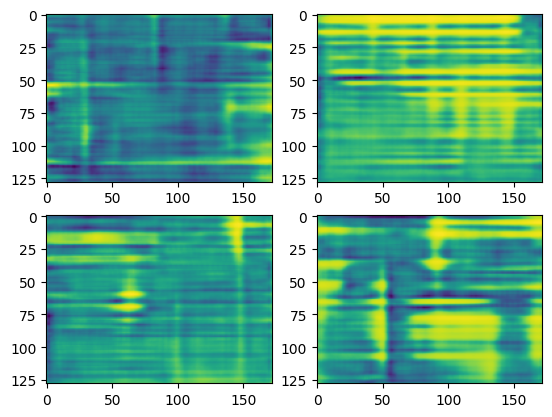

In [2]:
import matplotlib.pyplot as plt
import torch
from core.inference import load_model
conv = True
model, checkpoint = load_model('./models/deep_conv_vae/deep_c_vae_checkpoint_20250731-175016.pt', 'cuda', 'CVAE_Deep')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.eval()

z = torch.randn(4, checkpoint['config']['latent_dim']).to(device)
with torch.no_grad():
    samples = model.decode(z)
samples = samples.cpu().view(4, 128, 172).numpy()
plt.figure()
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(samples[i])

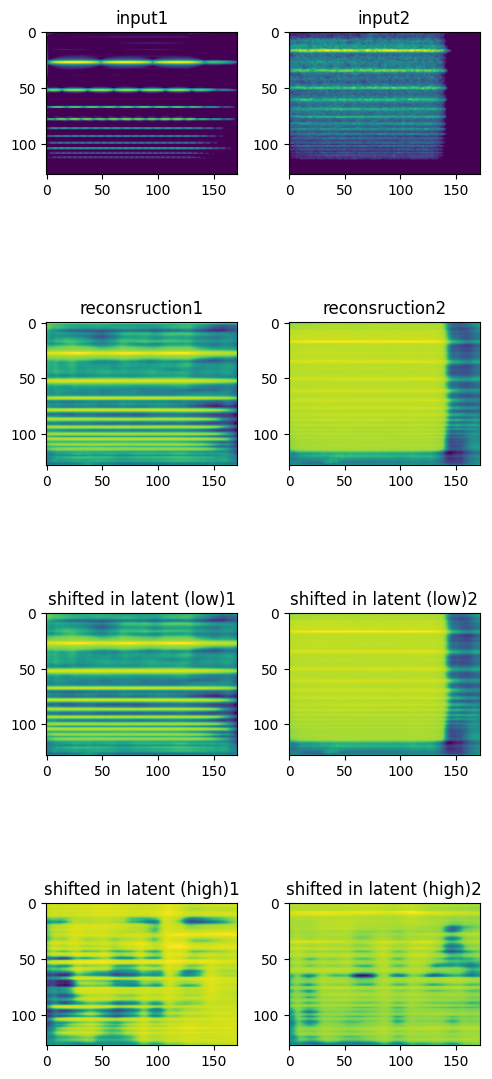

In [3]:
from datasets import HDF5SpectrogramDataset
from torch.utils.data import DataLoader
import numpy as np
num_samples = 2
train_data = HDF5SpectrogramDataset(project_root / 'data' / 'train_spectrograms_even.h5')
train_loader = DataLoader(train_data, batch_size=num_samples, shuffle=True)

inputs = next(iter(train_loader))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
inputs = inputs.to(device)
with torch.no_grad():
    if not conv:
        inputs = inputs.view(num_samples, -1)  # Flatten the data when not using convolutional VAE
    else:
        inputs = inputs.view(num_samples, 1, 128, 172)
    dist = model.encode(inputs)
    z_s = model.reparameterize(dist)
    recons = model.decode(z_s).cpu().view(num_samples, 128, 172).numpy()
    shifted_z_s_high = z_s + torch.rand_like(z_s) * 5.0
    shifted_z_s_low = z_s + torch.rand_like(z_s) * 000.1
    shifted_high = model.decode(shifted_z_s_high).cpu().view(num_samples, 128, 172).numpy()
    shifted_low = model.decode(shifted_z_s_low).cpu().view(num_samples, 128, 172).numpy()
    inputs = inputs.cpu().view(num_samples, 128, 172).numpy()
images = np.array([inputs, recons, shifted_high, shifted_low]).reshape((8, 128, 172))
plt.figure(figsize=[5,12])
for i in range(num_samples):
    plt.subplot(4,num_samples,i+1)
    plt.imshow(inputs[i])
    plt.title(f'input{i+1}')
    plt.subplot(4,num_samples,i+num_samples+1)
    plt.imshow(recons[i])
    plt.title(f'reconsruction{i+1}')
    plt.subplot(4,num_samples,i+2*num_samples+1)
    plt.imshow(shifted_low[i])
    plt.title(f'shifted in latent (low){i+1}')
    plt.subplot(4,num_samples,i+3*num_samples+1)
    plt.imshow(shifted_high[i])
    plt.title(f'shifted in latent (high){i+1}')
plt.tight_layout()



In [ ]:
import pandas as pd
df = pd.